In [3]:
import nglview as nv
import pytraj as pt 


print(dir(nv))


traj = pt.load(b, top=a); # "C499thistest_PDB.pdb"
nv.show_pytraj(traj)


['ASEStructure', 'ASETrajectory', 'BACKENDS', 'BiopythonStructure', 'DatasourceRegistry', 'FileStructure', 'HTMDTrajectory', 'IODataStructure', 'IOTBXStructure', 'MDAnalysisTrajectory', 'MDTrajTrajectory', 'NGLWidget', 'OpenbabelStructure', 'ParmEdTrajectory', 'PdbIdStructure', 'ProdyStructure', 'ProdyTrajectory', 'Psi4Structure', 'PyTrajTrajectory', 'QCElementalStructure', 'RdkitStructure', 'RosettaStructure', 'SchrodingerStructure', 'SchrodingerTrajectory', 'SimpletrajTrajectory', 'Structure', 'TextStructure', 'Trajectory', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', '_frontend', '_jupyter_nbextension_paths', '_version', 'adaptor', 'base', 'base_adaptor', 'color', 'component', 'config', 'data_source', 'datafiles', 'default', 'demo', 'interpolate', 'js_utils', 'layout', 'parameters', 'player', 'register_backend', 'remote_thread', 'representation', 'shape', 'show', 'show_ase', 'show_aset

NGLWidget(max_frame=5)

In [4]:
import nglview as nv 
import pytraj as pt
def rand_color():
  r = lambda: random.randint(0,255)
  return '#%02X%02X%02X' % (r(),r(),r())
def nglmask(traj, mask):
  return "@"+",".join([str(i) for i in traj.top.select(mask)])
def show_complex(traj, viewer_dic):
  viewer = nv.show_pytraj(traj)
  viewer[0].clear_representations()
  for i in viewer_dic:
    mask = nglmask(traj, i)
    viewer[0].add_representation(viewer_dic[i], selection=mask)
  viewer.center(selection=mask)
  viewer.stage.set_parameters(backgroundColor="#f9fcfd")
  return viewer



stride   = 1
masks    = {
  ":LIG,MDL<:15&!:SOL,T3P":"ribbon", 
  ":LIG,MDL<:5&!:SOL,T3P,WAT":"line", 
  ":LIG,MDL":"ball+stick", 
}; 
trajfile = "/storage006/yzhang/clean_acgui/TMP_FOLDERS/thistest/singleMD/C499thistest/C499thistest_TRJ.nc"; 
topfile  = "/storage006/yzhang/clean_acgui/TMP_FOLDERS/thistest/singleMD/C499thistest/C499thistest_PDB.pdb"; 
traj = pt.load(trajfile, top=topfile, stride=stride)
traj.top.set_reference(traj[0])
viewer = show_complex(traj, masks)
# print(dir(viewer))
viewer

NGLWidget(max_frame=5)

In [3]:
from BetaPose import utils, view
import nglview as nv 
import pytraj as pt


STRIDE   = 1
REPR    = {
  ":LIG,MDL<:15&!:SOL,T3P":"ribbon", 
  ":LIG,MDL<:5&!:SOL,T3P,WAT":"line", 
  ":LIG,MDL":"ball+stick", 
}; 

trajfile = "/storage006/yzhang/clean_acgui/TMP_FOLDERS/thistest/singleMD/C499thistest/C499thistest_TRJ.nc"; 
topfile  = "/storage006/yzhang/clean_acgui/TMP_FOLDERS/thistest/singleMD/C499thistest/C499thistest_PDB.pdb"; 

traj = pt.load(trajfile, top=topfile, stride=STRIDE);
traj.top.set_reference(traj[0]); 
viewer = view.show_complex(traj, REPR); 
dist, info = utils.PairwiseDistance(traj, ":LIG&!@H=", ":LIG<:6&@CA,C,N,O,CB")

print(dir(utils))
print(dist)
print(info)


# def add_distance(partner1, partner2):
#   for i, j in zip(partner1, partner2):
#     viewer[0].add_representation("distance", atomPair=[[f"@{i}", f"@{j}"]], 
#                                  color="blue", label_color="black", label_fontsize=0); 
#   return viewer

viewer = view.add_distance(viewer, info["gp1_ids"], info["gp2_ids"])
viewer

NameError: name 'self' is not defined

In [31]:
from BetaPose import utils, view
import nglview as nv 
import pytraj as pt
def nglmask(traj, mask):
  return "@"+",".join([str(i) for i in traj.top.select(mask)])
class TrajectoryViewer: 
  def __init__(self, traj):
    self.traj = traj; 
    self.viewer = nv.show_pytraj(traj); 
    
  def show_complex(self, viewer_dic):
    self.viewer[0].clear_representations(); 
    for rep in viewer_dic:
      mask = nglmask(self.traj, rep); 
      self.viewer[0].add_representation(viewer_dic[rep], selection=mask); 
    self.viewer.center(selection = mask); 
    self.viewer.stage.set_parameters(backgroundColor="#f9fcfd"); 
    return self.viewer
  def add_distance(self, partner1, partner2):
    for i, j in zip(partner1, partner2):
      self.viewer[0].add_representation("distance", atomPair=[[f"@{i}", f"@{j}"]],
                                   color="blue", label_color="black", label_fontsize=0.1);
    return self.viewer

  
STRIDE   = 1

# mask_lig = utils.getmask(traj, ":71&:PHE"); 
# mask_lig = ":71&:PHE"; 
mask_superpose = utils.getmask(traj, f"{mask_lig}<:6&@CA&!{mask_lig}");
mask_lig_pair1 = utils.getmask(traj, f"{mask_lig}&!@H="); 
mask_lig_pair2 = utils.getmask(traj, f"{mask_lig}<:6&@CA,C,N,O,CB&!{mask_lig}"); 

REPR    = {
  f"{mask_lig}<:15&!:SOL,T3P":"ribbon", 
  f"{mask_lig}<:5&!:SOL,T3P,WAT":"line", 
  f"{mask_lig}":"ball+stick", 
}; 

# trajid = "C006bfl1sim2"
# sessid = trajid[4:]

# trajfile = f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_TRJ.nc"; 
# topfile  = f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_PDB.pdb"; 

# traj = pt.load(trajfile, top=topfile, stride=STRIDE);
# traj.top.set_reference(traj[0]); 

# traj.superpose(":LIG<:5&@CA"); 
# traj.center(":LIG<:5&@CA"); 

tv = TrajectoryViewer(traj); 
tv.show_complex(REPR); 
dist, info = utils.PairwiseDistance(traj, mask_lig_pair1, mask_lig_pair2)
tv.add_distance(info["gp1_ids"], info["gp2_ids"])
tv.viewer
# from nglview.contrib.movie import MovieMaker
# download_folder = '/storage006/yzhang/tests/'
# output = 'test.gif'
# mov = MovieMaker(tv.viewer, download_folder=download_folder, output=output)
# mov.make()

NGLWidget(max_frame=200)

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from scipy.spatial import distance
from scipy import linalg

# Sum of the frames are they similar in values. 
print(f"Mean: {dist.mean()} ; Sum: {dist.sum()}")


sums = np.sum(dist, axis=0)
print(len(sums))
print(f"Mean: {sums.mean()} ; Std: {sums.std()}; Sum: {sums.sum()} , test = {dist.sum()/sums.mean()}, {dist.shape}")

print(6/200)

# plt.plot(sums)

# print(np.cov(dist.T))


# plt.pcolormesh(range(dist.shape[1]), range(dist.shape[0]), dist, cmap="inferno")
# plt.pcolormesh(range(201), range(33), dist, cmap="inferno")
# plt.pcolormesh(range(36), range(36), np.cov(theinv), cmap="inferno")
# print(dist.cov())
# print(dir(dist))


thecov = np.cov(dist)
theinv = linalg.inv(thecov)
meandist = dist.mean(axis=1)

# print(theinv)
# print(dist.shape[1])

def testmah(dist_mtx):
  thecov = np.cov(dist_mtx); 
  theinv = linalg.inv(thecov); 
  meandist = dist_mtx.mean(axis=1); 
  outarray = []
  for i in range(dist_mtx.shape[0]):
    disti = dist_mtx[:, i]; 
    thedist = distance.mahalanobis(meandist, disti, theinv)
    outarray.append(thedist)
  return np.array(outarray)
mahs = testmah(dist)
rmsd = pt.rmsd(traj, ":LIG&!@H="); 
print()
print(f"RMSD: {rmsd.mean()}, dist: {dist.mean()}, Mah: {mahs.mean()}")
print(f"RMSD: {rmsd.mean()}, dist: {dist.std()}, Mah: {mahs.std()}")
print(f"RMSD: {rmsd.mean()}, dist: {dist.mean()}, Mah: {mahs.mean()}")
print(f"RMSD: {rmsd.mean()}, dist: {dist.mean()}, Mah: {mahs.mean()}")
print(f"RMSD: {rmsd.mean()}, dist: {dist.std()/dist.mean()}, Mah: {mahs.std()/mahs.mean()}")


NameError: name 'dist' is not defined

In [30]:
import numpy as np 
import pytraj as pt
from scipy.spatial import distance
from scipy import linalg
from BetaPose import utils, view
import pandas as pd 

def testmah(dist_mtx):
  thecov = np.cov(dist_mtx); 
  theinv = linalg.inv(thecov); 
  meandist = dist_mtx.mean(axis=1); 
  # meandist = dist_mtx[:,0]; 
  outarray = []
  for i in range(dist_mtx.shape[0]):
    disti = dist_mtx[:, i]; 
    thedist = distance.mahalanobis(meandist, disti, theinv)
    outarray.append(thedist)
  return np.array(outarray)
def MSD(arr):
  return np.array(arr).std(axis=1).mean(); 
def MSVC(arr):
  std = np.array(arr).std(axis=1); 
  mean = np.array(arr).mean(axis=1); 
  msvc = (std/mean).mean()
  return min(msvc, 1); 

# def getmask(traj, mask): 
#   selected = traj.top.select(mask)
#   selected_str = [f"{i+1}," for i in selected]
#   finalmask = "@"+"".join(selected_str).strip(",")
#   return finalmask
  
  

STRIDE   = 1
RMSLST = []
DSTLST = []
MSDLST = []
MVCLST = []
TRAJID = []
c = 0
for i in range(1, 7):
  for j in range(3, 9): 
    trajid = f"C{j:03d}bfl1sim{i}"; 
    sessid = trajid[4:]; 

    trajfile = f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_TRJ.nc"; 
    topfile  = f"/storage006/yzhang/clean_acgui/TMP_FOLDERS/{sessid}/singleMD/{trajid}/{trajid}_PDB.pdb"; 
    
    traj = pt.load(trajfile, top=topfile, stride=STRIDE);
    traj.top.set_reference(traj[0]); 
    
    mask_lig = utils.getmask(traj, ":68&!@CA,CB,C,N,O"); 
    mask_superpose = utils.getmask(traj, f"{mask_lig}<:6&@CA&!{mask_lig}");
    mask_lig_pair1 = utils.getmask(traj, f"{mask_lig}&!@H="); 
    mask_lig_pair2 = utils.getmask(traj, f"{mask_lig}<:6&@CA,C,N,O,CB&!{mask_lig}"); 
    
    traj.superpose(mask_superpose);
    # traj.center(mask_superpose);

    mask_lig_pair1 = utils.getmask(traj, f"{mask_lig}&!@H=")
    mask_lig_pair2 = utils.getmask(traj, f"{mask_lig}<:6&@CA,C,N,O,CB&!{mask_lig}")
    dist, info = utils.PairwiseDistance(traj, mask_lig_pair1, mask_lig_pair2)
    dist += 0.0000001
    
    try: 
      mahs = testmah(dist)
    except: 
      mahs = np.zeros([dist.shape[0]])
    rmsds = pt.rmsd(traj, mask_lig_pair1); 
    
    rmsd = rmsds.mean()
    mdist = dist.mean(); 
    msd = MSD(dist); 
    msvc = MSVC(dist); 
    TRAJID.append(trajid); 
    RMSLST.append(rmsd)
    DSTLST.append(mdist)
    MSDLST.append(msd)
    MVCLST.append(msvc)
    print(f"{trajid}:{c:>3d} - RMSD: {rmsd:.2f} | Dist: {mdist:>5.2f} | MSD: {msd:>6.3f} | MSVC: {msvc:4.3f} | Mah: {mahs.mean() - MSVC(dist)*mahs.mean():>5.2f} ;")
    c+=1
    
finallst = pd.DataFrame([])
finallst["TRAJ"] = TRAJID
finallst["RMS"] = RMSLST
finallst["DIST"] = DSTLST
finallst["MSD"] = MSDLST
finallst["MSVC"] = MVCLST
print(finallst)

C003bfl1sim1:  0 - RMSD: 0.17 | Dist:  3.28 | MSD:  0.206 | MSVC: 0.055 | Mah:  2.10 ;
C004bfl1sim1:  1 - RMSD: 0.15 | Dist:  3.51 | MSD:  0.312 | MSVC: 0.074 | Mah:  1.93 ;
C005bfl1sim1:  2 - RMSD: 0.19 | Dist:  3.29 | MSD:  0.229 | MSVC: 0.060 | Mah:  2.38 ;
C006bfl1sim1:  3 - RMSD: 0.18 | Dist:  3.25 | MSD:  0.225 | MSVC: 0.060 | Mah:  1.84 ;
C007bfl1sim1:  4 - RMSD: 0.36 | Dist:  3.50 | MSD:  0.343 | MSVC: 0.084 | Mah:  2.25 ;
C008bfl1sim1:  5 - RMSD: 0.41 | Dist:  3.78 | MSD:  0.639 | MSVC: 0.140 | Mah:  1.78 ;
C003bfl1sim2:  6 - RMSD: 0.38 | Dist:  3.51 | MSD:  0.282 | MSVC: 0.070 | Mah:  2.09 ;
C004bfl1sim2:  7 - RMSD: 0.41 | Dist:  3.45 | MSD:  0.258 | MSVC: 0.066 | Mah:  1.95 ;
C005bfl1sim2:  8 - RMSD: 0.17 | Dist:  3.35 | MSD:  0.297 | MSVC: 0.075 | Mah:  2.27 ;
C006bfl1sim2:  9 - RMSD: 0.15 | Dist:  3.27 | MSD:  0.241 | MSVC: 0.063 | Mah:  1.95 ;
C007bfl1sim2: 10 - RMSD: 0.22 | Dist:  3.35 | MSD:  0.230 | MSVC: 0.059 | Mah:  2.49 ;
C008bfl1sim2: 11 - RMSD: 0.22 | Dist:  3.32

0.16482411 0.12345735356211662
[[0.00587643 0.00621004 0.00352814 0.00065761]
 [0.00621004 0.03153506 0.02470809 0.00401433]
 [0.00352814 0.02470809 0.02280823 0.00386671]
 [0.00065761 0.00401433 0.00386671 0.00067943]]
[[   344.38737513   -278.08423867    737.46308123  -2887.29668535]
 [  -278.08423867    510.65476606  -1259.52486714   4420.12509972]
 [   737.46308123  -1259.52486714   4366.85675716 -18124.36454795]
 [ -2887.29668535   4420.12509972 -18124.36454795  81298.6938147 ]]
0.1574791040518532 0.054572058462214613


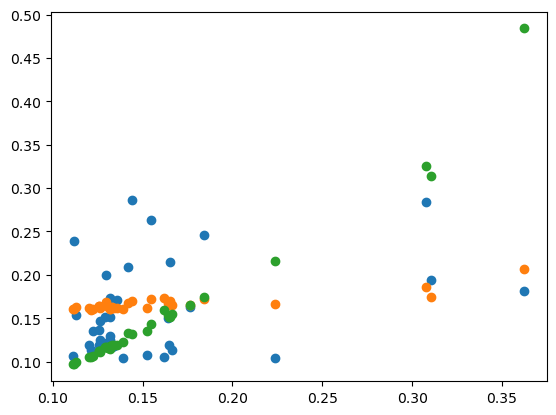

In [32]:
from sklearn.preprocessing import normalize
# import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 
# plt.scatter(finallst.MSD, finallst.RMS)
# plt.scatter(finallst.MSVC, finallst.RMS)
# plt.scatter(finallst.MSVC, finallst.MSD)
# plt.scatter(finallst.MSVC, finallst.DIST)
# sns.pairplot(finallst)
vals = finallst[["RMS", "DIST", "MSD", "MSVC"]].to_numpy().T


print(finallst.MSVC.max(), finallst.MSVC.mean() + 2*finallst.MSVC.std())


def reject_outliers(data, m=2):
  finallst.MSVC.mean() + 2*finallst.MSVC.std()
#   np.where(data<)




vals_norm = normalize(vals)
print(np.cov(vals))
print(linalg.inv(np.cov(vals)))
# vals_norm = vals
print(vals_norm.mean(), vals_norm.std())

plt.scatter(vals_norm[3,:], vals_norm[0,:])
plt.scatter(vals_norm[3,:], vals_norm[1,:])
plt.scatter(vals_norm[3,:], vals_norm[2,:])


# plt.pcolormesh(range(vals_norm.shape[1]), range(vals_norm.shape[0]), vals_norm)


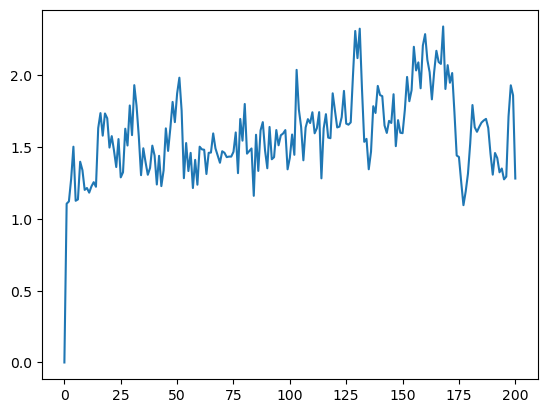

In [34]:
plt.plot(rmsds)

In [2]:
from nglview.contrib.movie import MovieMaker
download_folder = "/home/miemie/Downloads"
output = 'test.gif'
mov = MovieMaker(tv.viewer, download_folder=download_folder, in_memory=True, output=output)
mov.make()

IntProgress(value=0, description='Rendering ...', max=200)

In [5]:
from time import sleep

# to save time for this tutorial, we make a movie with only 50 frames
for frame in range(0, 50):
    # set frame to update coordinates
    tv.viewer.frame = frame
    # make sure to let NGL spending enough time to update coordinates
    sleep(0.5)
    tv.viewer.download_image(filename=f'image{frame}.png')
    # make sure to let NGL spending enough time to render before going to next frame
    sleep(1.0)



ModuleNotFoundError: No module named 'moviepy'

In [4]:
# import moviepy
import moviepy.editor as mpy


imagefiles = [f"/home/miemie/Downloads/image{i}.png" for i in range(0, 50, 1)]
print(imagefiles)

frame_per_second = 8
im = mpy.ImageSequenceClip(imagefiles, fps=frame_per_second)
im.write_gif('my_movie.gif', fps=frame_per_second)


['/home/miemie/Downloads/image0.png', '/home/miemie/Downloads/image1.png', '/home/miemie/Downloads/image2.png', '/home/miemie/Downloads/image3.png', '/home/miemie/Downloads/image4.png', '/home/miemie/Downloads/image5.png', '/home/miemie/Downloads/image6.png', '/home/miemie/Downloads/image7.png', '/home/miemie/Downloads/image8.png', '/home/miemie/Downloads/image9.png', '/home/miemie/Downloads/image10.png', '/home/miemie/Downloads/image11.png', '/home/miemie/Downloads/image12.png', '/home/miemie/Downloads/image13.png', '/home/miemie/Downloads/image14.png', '/home/miemie/Downloads/image15.png', '/home/miemie/Downloads/image16.png', '/home/miemie/Downloads/image17.png', '/home/miemie/Downloads/image18.png', '/home/miemie/Downloads/image19.png', '/home/miemie/Downloads/image20.png', '/home/miemie/Downloads/image21.png', '/home/miemie/Downloads/image22.png', '/home/miemie/Downloads/image23.png', '/home/miemie/Downloads/image24.png', '/home/miemie/Downloads/image25.png', '/home/miemie/Downloa

OSError: No such file: '/home/miemie/Downloads/image0.png'